In [1]:
# California Prop 99 Analysis: Comparing DiD, SC, and Optimized SC Methods
# with Particle Swarm Optimization for Hyperparameter Tuning (may or may not work)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.family'] = 'serif'
sns.set_context("notebook", font_scale=1.1)


In [18]:
class CaliforniaProp99Analyzer:
    """
    Analyze the effects of California's Proposition 99 on cigarette consumption 
    using multiple methods: DiD, SC, and enhanced SC with PSO optimization.
    """
    
    def __init__(self, data_path="prop99.csv", 
                 treated_state="California", treatment_year=1989,
                 exclude_neighbors=True, start_year=1970, end_year=2000):
        """
        Initialize the analyzer with data and parameters.
        
        Args:
            data_path: Path to CSV data file
            treated_state: State that received the treatment
            treatment_year: Year when the treatment was implemented
            exclude_neighbors: Whether to exclude neighboring states
            start_year: First year to include in analysis
            end_year: Last year to include in analysis
        """
        self.data_path = data_path
        self.treated_state = treated_state
        self.treatment_year = treatment_year
        self.start_year = start_year
        self.end_year = end_year
        
        # Define neighboring states to potentially exclude
        self.neighboring_states = ["Nevada", "Oregon", "Arizona"]
        self.exclude_neighbors = exclude_neighbors
        
        # Data containers
        self.df = None
        self.states = None
        self.years = None
        self.pre_years = None
        self.post_years = None
        
        # Matrices for analysis
        self.Y_treated_pre = None
        self.Y_treated_post = None
        self.Y_control_pre = None
        self.Y_control_post = None
        
        # Results from different methods
        self.results = {}
        
        # Load and process data
        self._load_data()
        self._prepare_matrices()
    
    def _load_data(self):
        """Load and preprocess the data."""
        try:
            # Load the dataset
            df_raw = pd.read_csv(self.data_path)
            
            # Find the cigarette consumption measure
            measure_options = ["Cigarette Consumption", "Pack Sales Per Capita", "cigsale"]
            found_measure = None
            
            for measure in measure_options:
                if 'SubMeasureDesc' in df_raw.columns:
                    df_filtered = df_raw[df_raw['SubMeasureDesc'].str.contains(measure, case=False, na=False)]
                    if len(df_filtered) > 0:
                        found_measure = measure
                        break
            
            if found_measure is None:
                raise ValueError("Could not find cigarette consumption data in the dataset")
            
            # Standardize column names
            if 'LocationDesc' in df_filtered.columns:
                df_filtered['state'] = df_filtered['LocationDesc']
            
            if 'Year' in df_filtered.columns:
                df_filtered['year'] = df_filtered['Year'].astype(int)
            
            if 'Data_Value' in df_filtered.columns:
                df_filtered['cigsale'] = df_filtered['Data_Value'].astype(float)
            
            # Filter by year range
            self.df = df_filtered[
                (df_filtered['year'] >= self.start_year) & 
                (df_filtered['year'] <= self.end_year)
            ][['state', 'year', 'cigsale']].copy()
            
            # Exclude neighboring states if requested
            if self.exclude_neighbors:
                self.df = self.df[~self.df['state'].isin(self.neighboring_states)]
            
            # Add treatment indicators
            self.df['treated'] = (self.df['state'] == self.treated_state).astype(int)
            self.df['post'] = (self.df['year'] >= self.treatment_year).astype(int)
            
            # Extract unique states and years
            self.states = sorted(self.df['state'].unique())
            self.years = sorted(self.df['year'].unique())
            self.pre_years = [y for y in self.years if y < self.treatment_year]
            self.post_years = [y for y in self.years if y >= self.treatment_year]
            
            # Define state lists
            self.treated_states = [self.treated_state]
            self.control_states = [s for s in self.states if s != self.treated_state]
            
            print(f"Data loaded successfully: {len(self.states)} states, {len(self.years)} years")
            print(f"Pre-treatment period: {min(self.pre_years)}-{max(self.pre_years)} ({len(self.pre_years)} years)")
            print(f"Post-treatment period: {min(self.post_years)}-{max(self.post_years)} ({len(self.post_years)} years)")
            
            # Check for missing values
            missing = self.df['cigsale'].isna().sum()
            if missing > 0:
                print(f"Warning: {missing} missing values detected. Filling with state means.")
                self.df['cigsale'] = self.df.groupby('state')['cigsale'].transform(
                    lambda x: x.fillna(x.mean())
                )
            
        except Exception as e:
            raise RuntimeError(f"Error loading data: {str(e)}")
    
    def _prepare_matrices(self):
        """Prepare data matrices for analysis."""
        # Create a pivot table of cigarette sales
        pivot = self.df.pivot(index='year', columns='state', values='cigsale')
        
        # Extract treated unit data
        treated_series = pivot[self.treated_state]
        
        # Extract control units data
        control_matrix = pivot[self.control_states]
        
        # Split into pre and post treatment periods
        self.Y_treated_pre = treated_series[treated_series.index < self.treatment_year].values
        self.Y_treated_post = treated_series[treated_series.index >= self.treatment_year].values
        
        self.Y_control_pre = control_matrix[control_matrix.index < self.treatment_year].values
        self.Y_control_post = control_matrix[control_matrix.index >= self.treatment_year].values
        
        print(f"Analysis matrices prepared: {self.Y_control_pre.shape[1]} control units, "
              f"{len(self.Y_treated_pre)} pre-treatment periods, "
              f"{len(self.Y_treated_post)} post-treatment periods")
    
    def run_did(self):
        """Run difference-in-differences analysis."""
        print("Running Difference-in-Differences analysis...")
        
        # Calculate group means
        treated_pre = self.df[(self.df['treated'] == 1) & (self.df['post'] == 0)]['cigsale'].mean()
        treated_post = self.df[(self.df['treated'] == 1) & (self.df['post'] == 1)]['cigsale'].mean()
        control_pre = self.df[(self.df['treated'] == 0) & (self.df['post'] == 0)]['cigsale'].mean()
        control_post = self.df[(self.df['treated'] == 0) & (self.df['post'] == 1)]['cigsale'].mean()
        
        # Calculate DiD estimate
        did_effect = (treated_post - treated_pre) - (control_post - control_pre)
        
        # Calculate synthetic control values
        synth_pre = np.ones_like(self.Y_treated_pre) * control_pre
        synth_post = np.ones_like(self.Y_treated_post) * control_post
        
        # Calculate year-by-year treatment effects
        effects = self.Y_treated_post - (synth_post + (self.Y_treated_pre.mean() - control_pre))
        
        # Calculate fit metrics
        pre_rmse = np.sqrt(np.mean((self.Y_treated_pre - (synth_pre + (self.Y_treated_pre.mean() - control_pre)))**2))
        
        # Calculate standard error using stata-like cluster-robust approach
        # This simple implementation assumes clustering by year
        y_actual = np.concatenate([self.Y_treated_pre, self.Y_treated_post])
        y_synth = np.concatenate([synth_pre + (self.Y_treated_pre.mean() - control_pre), 
                                  synth_post + (self.Y_treated_pre.mean() - control_pre)])
        did_se = np.std(y_actual - y_synth) / np.sqrt(len(self.post_years))
        
        # Store results
        self.results['did'] = {
            'weights': np.ones(len(self.control_states)) / len(self.control_states),
            'mu': treated_pre - control_pre,
            'synth_pre': synth_pre + (self.Y_treated_pre.mean() - control_pre),
            'synth_post': synth_post + (self.Y_treated_pre.mean() - control_pre),
            'effects': effects,
            'avg_effect': did_effect,
            'se': did_se,
            'pre_rmse': pre_rmse,
            'method': 'Difference-in-Differences'
        }
        
        print(f"DiD Analysis - Average Treatment Effect: {did_effect:.2f} (SE: {did_se:.2f})")
        return self.results['did']
    
    def run_synthetic_control(self):
        """Run standard synthetic control analysis."""
        print("Running Standard Synthetic Control analysis...")
        
        # Define objective function
        def sc_objective(w):
            return np.sum((self.Y_treated_pre - self.Y_control_pre.dot(w))**2)
        
        # Define constraints: weights sum to one
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        
        # Non-negative weights
        bounds = [(0, None) for _ in range(self.Y_control_pre.shape[1])]
        
        # Initial weights (uniform)
        w0 = np.ones(self.Y_control_pre.shape[1]) / self.Y_control_pre.shape[1]
        
        # Solve optimization
        result = minimize(
            sc_objective, w0, method='SLSQP',
            bounds=bounds, constraints=constraints,
            options={'ftol': 1e-10, 'maxiter': 5000}
        )
        
        weights = result.x
        
        # Calculate synthetic values
        synth_pre = self.Y_control_pre.dot(weights)
        synth_post = self.Y_control_post.dot(weights)
        
        # Calculate treatment effects
        effects = self.Y_treated_post - synth_post
        avg_effect = np.mean(effects)
        
        # Calculate fit metrics
        pre_rmse = np.sqrt(np.mean((self.Y_treated_pre - synth_pre)**2))
        
        # Calculate placebo-based standard error
        se = self._calculate_placebo_se(weights, method='standard_sc')
        
        # Store results
        self.results['sc'] = {
            'weights': weights,
            'mu': 0,  # Standard SC doesn't include an intercept
            'synth_pre': synth_pre,
            'synth_post': synth_post,
            'effects': effects,
            'avg_effect': avg_effect,
            'se': se,
            'pre_rmse': pre_rmse,
            'method': 'Synthetic Control'
        }
        
        print(f"SC Analysis - Average Treatment Effect: {avg_effect:.2f} (SE: {se:.2f}), Pre-treatment RMSE: {pre_rmse:.2f}")
        return self.results['sc']
    
    def run_elastic_net_sc(self, alpha=0.1, l1_ratio=0.5):
        """
        Run Elastic Net Synthetic Control with L1 and L2 regularization.
        
        Args:
            alpha: Overall regularization strength
            l1_ratio: Ratio of L1 to L2 regularization (1 = Lasso, 0 = Ridge)
        """
        print(f"Running Elastic Net SC (α={alpha}, L1 ratio={l1_ratio})...")
        
        # Fit elastic net (without intercept)
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            fit_intercept=False,
            positive=True,  # Enforce non-negativity
            max_iter=10000,
            tol=1e-6
        )
        
        model.fit(self.Y_control_pre, self.Y_treated_pre)
        
        # Get weights
        weights_raw = model.coef_
        
        # Normalize weights to sum to 1
        weights = weights_raw / np.sum(weights_raw) if np.sum(weights_raw) > 0 else weights_raw
        
        # Calculate synthetic values
        synth_pre = self.Y_control_pre.dot(weights)
        synth_post = self.Y_control_post.dot(weights)
        
        # Calculate treatment effects
        effects = self.Y_treated_post - synth_post
        avg_effect = np.mean(effects)
        
        # Calculate fit metrics
        pre_rmse = np.sqrt(np.mean((self.Y_treated_pre - synth_pre)**2))
        
        # Calculate placebo-based standard error
        se = self._calculate_placebo_se(weights, method='elastic_net')
        
        # Store results
        self.results['elastic_net'] = {
            'weights': weights,
            'mu': 0,  # Elastic Net SC without intercept
            'synth_pre': synth_pre,
            'synth_post': synth_post,
            'effects': effects,
            'avg_effect': avg_effect,
            'se': se,
            'pre_rmse': pre_rmse,
            'method': f'Elastic Net SC (α={alpha}, L1 ratio={l1_ratio})'
        }
        
        print(f"Elastic Net SC - Average Treatment Effect: {avg_effect:.2f} (SE: {se:.2f}), Pre-treatment RMSE: {pre_rmse:.2f}")
        return self.results['elastic_net']
    
    def run_optimized_sc(self, lambda_l1=0.01, lambda_l2=0.01, intercept=True):
        """
        Run optimized synthetic control with L1 and L2 penalties and optional intercept.
        
        Args:
            lambda_l1: L1 regularization parameter
            lambda_l2: L2 regularization parameter
            intercept: Whether to include an intercept term
        """
        print(f"Running Optimized SC (λ1={lambda_l1}, λ2={lambda_l2}, intercept={intercept})...")
        
        # Number of control units
        J = self.Y_control_pre.shape[1]
        
        # Define objective function with L1 and L2 penalties
        def optimized_objective(params):
            if intercept:
                mu = params[0]
                w = params[1:]
                residuals = self.Y_treated_pre - mu - self.Y_control_pre.dot(w)
            else:
                w = params
                residuals = self.Y_treated_pre - self.Y_control_pre.dot(w)
            
            # Main loss
            main_loss = np.mean(residuals**2)
            
            # L1 penalty (lasso)
            l1_penalty = lambda_l1 * np.sum(np.abs(w))
            
            # L2 penalty (ridge)
            l2_penalty = lambda_l2 * np.sum(w**2)
            
            return main_loss + l1_penalty + l2_penalty
        
        # Initial values
        if intercept:
            params0 = np.zeros(J + 1)
            params0[1:] = np.ones(J) / J  # Uniform weights to start
        else:
            params0 = np.ones(J) / J
        
        # No constraints on sum of weights for flexibility
        result = minimize(
            optimized_objective, params0, method='L-BFGS-B',
            bounds=[(None, None) if (intercept and i == 0) else (0, None) for i in range(len(params0))],
            options={'ftol': 1e-10, 'maxiter': 5000}
        )
        
        if intercept:
            mu = result.x[0]
            weights = result.x[1:]
        else:
            mu = 0
            weights = result.x
        
        # Calculate synthetic values
        synth_pre = self.Y_control_pre.dot(weights) + mu
        synth_post = self.Y_control_post.dot(weights) + mu
        
        # Calculate treatment effects
        effects = self.Y_treated_post - synth_post
        avg_effect = np.mean(effects)
        
        # Calculate fit metrics
        pre_rmse = np.sqrt(np.mean((self.Y_treated_pre - synth_pre)**2))
        
        # Calculate placebo-based standard error
        se = self._calculate_placebo_se(weights, mu=mu, method='optimized')
        
        # Store results
        method_name = f'Optimized SC (λ1={lambda_l1}, λ2={lambda_l2}, intercept={intercept})'
        self.results['optimized_sc'] = {
            'weights': weights,
            'mu': mu,
            'synth_pre': synth_pre,
            'synth_post': synth_post,
            'effects': effects,
            'avg_effect': avg_effect,
            'se': se,
            'pre_rmse': pre_rmse,
            'method': method_name
        }
        
        print(f"Optimized SC - Average Treatment Effect: {avg_effect:.2f} (SE: {se:.2f}), Pre-treatment RMSE: {pre_rmse:.2f}")
        return self.results['optimized_sc']
    
    def run_pso_optimized_sc(self, population_size=20, iterations=30, 
                            lambda_l1_range=(0.001, 0.2), lambda_l2_range=(0.001, 0.2), 
                            with_intercept=True):
        """
        Run Particle Swarm Optimization to find the best hyperparameters for synthetic control.
        
        Args:
            population_size: Number of particles in the swarm
            iterations: Maximum number of iterations
            lambda_l1_range: Range for L1 regularization parameter
            lambda_l2_range: Range for L2 regularization parameter
            with_intercept: Whether to include an intercept
        """
        print(f"Running PSO Optimized SC (population={population_size}, iterations={iterations})...")
        
        # Number of control units
        J = self.Y_control_pre.shape[1]
        
        # Use cross-validation to evaluate particles
        # Split pre-treatment data into training and validation sets
        T_pre = len(self.Y_treated_pre)
        val_size = max(1, T_pre // 5)  # Use 20% for validation
        train_idx = np.arange(T_pre - val_size)
        val_idx = np.arange(T_pre - val_size, T_pre)
        
        Y_train = self.Y_treated_pre[train_idx]
        X_train = self.Y_control_pre[train_idx, :]
        Y_val = self.Y_treated_pre[val_idx]
        X_val = self.Y_control_pre[val_idx, :]
        
        # Define particle class for PSO
        class Particle:
            def __init__(self, with_intercept=True):
                self.with_intercept = with_intercept
                # Initialize position (λ1, λ2, w0)
                self.position = np.array([
                    np.random.uniform(lambda_l1_range[0], lambda_l1_range[1]),
                    np.random.uniform(lambda_l2_range[0], lambda_l2_range[1])
                ])
                # Initialize velocity
                self.velocity = np.array([
                    np.random.uniform(-0.1, 0.1),
                    np.random.uniform(-0.1, 0.1)
                ])
                # Initialize best position and value
                self.best_position = self.position.copy()
                self.best_value = float('inf')
                # Initialize solution (weights and intercept)
                self.solution = None
            
            def evaluate(self):
                """Evaluate particle by fitting model with current hyperparameters"""
                lambda_l1, lambda_l2 = self.position
                
                # Define objective function
                def obj_func(params):
                    if self.with_intercept:
                        mu = params[0]
                        weights = params[1:]
                        residuals = Y_train - mu - X_train.dot(weights)
                    else:
                        weights = params
                        residuals = Y_train - X_train.dot(weights)
                    
                    # Main loss
                    main_loss = np.mean(residuals**2)
                    
                    # L1 penalty
                    l1_penalty = lambda_l1 * np.sum(np.abs(weights))
                    
                    # L2 penalty
                    l2_penalty = lambda_l2 * np.sum(weights**2)
                    
                    return main_loss + l1_penalty + l2_penalty
                
                # Initial parameters
                if self.with_intercept:
                    params0 = np.zeros(J + 1)
                    params0[1:] = np.ones(J) / J
                else:
                    params0 = np.ones(J) / J
                
                # Solve optimization problem
                try:
                    result = minimize(
                        obj_func, params0, method='L-BFGS-B',
                        bounds=[(None, None) if (self.with_intercept and i == 0) else (0, None) 
                                for i in range(len(params0))],
                        options={'ftol': 1e-6, 'maxiter': 500}
                    )
                    
                    # Extract solution
                    if self.with_intercept:
                        mu = result.x[0]
                        weights = result.x[1:]
                    else:
                        mu = 0
                        weights = result.x
                    
                    # Store solution
                    self.solution = (weights, mu)
                    
                    # Calculate validation score
                    val_pred = X_val.dot(weights) + mu
                    score = np.sqrt(np.mean((Y_val - val_pred)**2))
                    
                    return score
                except:
                    # If optimization fails, return a high score
                    return float('inf')
            
            def update_velocity(self, global_best_position, w=0.7, c1=1.5, c2=1.5):
                """Update velocity based on PSO formula"""
                r1, r2 = np.random.rand(2)
                cognitive = c1 * r1 * (self.best_position - self.position)
                social = c2 * r2 * (global_best_position - self.position)
                self.velocity = w * self.velocity + cognitive + social
            
            def update_position(self):
                """Update position based on velocity"""
                self.position = self.position + self.velocity
                # Clip position to valid range
                self.position[0] = np.clip(self.position[0], lambda_l1_range[0], lambda_l1_range[1])
                self.position[1] = np.clip(self.position[1], lambda_l2_range[0], lambda_l2_range[1])
        
        # Initialize particles
        particles = [Particle(with_intercept=with_intercept) for _ in range(population_size)]
        
        # Initialize global best
        global_best_position = None
        global_best_value = float('inf')
        global_best_solution = None
        
        # Run PSO iterations
        history = []
        
        for iteration in range(iterations):
            for particle in particles:
                # Evaluate particle
                value = particle.evaluate()
                
                # Update particle's best
                if value < particle.best_value:
                    particle.best_value = value
                    particle.best_position = particle.position.copy()
                
                # Update global best
                if value < global_best_value:
                    global_best_value = value
                    global_best_position = particle.position.copy()
                    global_best_solution = particle.solution
            
            # Track best value at this iteration
            history.append((iteration, global_best_value, global_best_position.copy()))
            
            print(f"Iteration {iteration+1}/{iterations}: Best RMSE = {global_best_value:.4f}, "
                  f"λ1 = {global_best_position[0]:.4f}, λ2 = {global_best_position[1]:.4f}")
            
            # Update particles
            for particle in particles:
                particle.update_velocity(global_best_position)
                particle.update_position()
        
        # Extract the best solution
        weights, mu = global_best_solution
        best_lambda_l1, best_lambda_l2 = global_best_position
        
        # Apply the best solution to the full pre-treatment data
        synth_pre = self.Y_control_pre.dot(weights) + mu
        synth_post = self.Y_control_post.dot(weights) + mu
        
        # Calculate treatment effects
        effects = self.Y_treated_post - synth_post
        avg_effect = np.mean(effects)
        
        # Calculate fit metrics
        pre_rmse = np.sqrt(np.mean((self.Y_treated_pre - synth_pre)**2))
        
        # Calculate placebo-based standard error
        se = self._calculate_placebo_se(weights, mu=mu, method='pso')
        
        # Store results
        method_name = f'PSO Optimized SC (λ1={best_lambda_l1:.4f}, λ2={best_lambda_l2:.4f}, intercept={with_intercept})'
        self.results['pso_sc'] = {
            'weights': weights,
            'mu': mu,
            'synth_pre': synth_pre,
            'synth_post': synth_post,
            'effects': effects,
            'avg_effect': avg_effect,
            'se': se,
            'pre_rmse': pre_rmse,
            'method': method_name,
            'best_lambda_l1': best_lambda_l1,
            'best_lambda_l2': best_lambda_l2,
            'history': history
        }
        
        print(f"PSO Optimized SC - Best Parameters: λ1={best_lambda_l1:.4f}, λ2={best_lambda_l2:.4f}")
        print(f"Average Treatment Effect: {avg_effect:.2f} (SE: {se:.2f}), Pre-treatment RMSE: {pre_rmse:.2f}")
        
        return self.results['pso_sc']
    
    def _calculate_placebo_se(self, weights, mu=0, method='standard_sc', n_placebos=10):
        """
        Calculate standard errors using placebo tests.
        
        Args:
            weights: SC weights
            mu: Intercept term (0 for standard SC)
            method: Method being used
            n_placebos: Number of placebo runs to perform
            
        Returns:
            Standard error of treatment effect
        """
        # Generate placebo effects by treating each control state as if it were treated
        placebo_effects = []
        
        # Use a subset of control states for efficiency
        if len(self.control_states) > n_placebos:
            np.random.seed(42)  # For reproducibility
            placebo_states_idx = np.random.choice(len(self.control_states), n_placebos, replace=False)
        else:
            placebo_states_idx = range(len(self.control_states))
        
        for i in placebo_states_idx:
            # Create leave-one-out matrices
            placebo_Y_treated_pre = self.Y_control_pre[:, i]
            placebo_Y_treated_post = self.Y_control_post[:, i]
            
            placebo_Y_control_pre = np.delete(self.Y_control_pre, i, axis=1)
            placebo_Y_control_post = np.delete(self.Y_control_post, i, axis=1)
            
            # Compute synthetic control for this placebo
            # For simplicity, we use the same weights but reweighted
            placebo_weights = np.delete(weights, i)
            if sum(placebo_weights) > 0:
                placebo_weights = placebo_weights / sum(placebo_weights)
            
            # Calculate synthetic values
            placebo_synth_pre = placebo_Y_control_pre.dot(placebo_weights) + mu
            placebo_synth_post = placebo_Y_control_post.dot(placebo_weights) + mu
            
            # Calculate placebo effect
            placebo_effect = np.mean(placebo_Y_treated_post - placebo_synth_post)
            placebo_effects.append(placebo_effect)
        
        # Calculate standard error from the distribution of placebo effects
        se = np.std(placebo_effects)
        
        return se
    
    def run_bayesian_inference(self, method='pso_sc', n_samples=1000):
        """
        Run Bayesian inference for uncertainty estimation.
        
        Args:
            method: Method to use for inference (must be already run)
            n_samples: Number of posterior samples
            
        Returns:
            Dictionary with posterior samples and credible intervals
        """
        if method not in self.results:
            raise ValueError(f"Method {method} not found in results. Run this method first.")
        
        print(f"Running Bayesian inference for {method}...")
        
        # Get results from the specified method
        result = self.results[method]
        weights = result['weights']
        mu = result['mu']
        
        # Extract residuals from pre-treatment period
        residuals = self.Y_treated_pre - (self.Y_control_pre.dot(weights) + mu)
        
        # Estimate noise variance
        sigma2 = np.var(residuals)
        
        # Generate posterior samples
        np.random.seed(42)  # For reproducibility
        posterior_samples = []
        
        for _ in range(n_samples):
            # Sample noise terms for post-treatment period
            noise_samples = np.random.normal(0, np.sqrt(sigma2), len(self.Y_treated_post))
            
            # Generate counterfactual outcomes
            counterfactual = self.Y_control_post.dot(weights) + mu + noise_samples
            
            # Calculate treatment effects
            sample_effects = self.Y_treated_post - counterfactual
            sample_avg_effect = np.mean(sample_effects)
            
            posterior_samples.append(sample_avg_effect)
        
        # Calculate credible intervals
        ci_05 = np.percentile(posterior_samples, 5)
        ci_95 = np.percentile(posterior_samples, 95)
        
        # Store inference results
        self.results[method]['bayesian'] = {
            'posterior_samples': posterior_samples,
            'ci_05': ci_05,
            'ci_95': ci_95,
            'posterior_mean': np.mean(posterior_samples),
            'posterior_sd': np.std(posterior_samples)
        }
        
        print(f"Bayesian inference completed: 90% credible interval [{ci_05:.2f}, {ci_95:.2f}]")
        return self.results[method]['bayesian']
         
    def plot_results(self, methods=None, plot_gap=True, show_uncertainty=True, separate_plots=True):
        """
        Plot the results of the analyses with improved formatting.
        
        Args:
            methods: List of methods to plot (defaults to all)
            plot_gap: Whether to plot the gap (treatment effect) below the main plot
            show_uncertainty: Whether to display uncertainty intervals
            separate_plots: Whether to create separate plots for each method's CI
        """
        if methods is None:
            methods = list(self.results.keys())
        
        # Create main figure
        if plot_gap:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})
        else:
            fig, ax1 = plt.subplots(figsize=(14, 7))
        
        # Plot actual values for treated unit
        all_years = np.concatenate([self.pre_years, self.post_years])
        treated_values = np.concatenate([self.Y_treated_pre, self.Y_treated_post])
        ax1.plot(all_years, treated_values, 'k-', linewidth=2.5, label=f'{self.treated_state} (Actual)')
        
        # Colors for different methods - using distinct colors
        colors = {
            'did': '#1f77b4',         # blue
            'sc': '#d62728',          # red
            'elastic_net': '#2ca02c',  # green
            'optimized_sc': '#9467bd', # purple
            'pso_sc': '#ff7f0e'        # orange
        }
        
        linestyles = {
            'did': '-',
            'sc': '--',
            'elastic_net': ':',
            'optimized_sc': '-.',
            'pso_sc': '-'
        }
        
        # Plot synthetic values and gaps for each method
        for method in methods:
            if method not in self.results:
                continue
            
            results = self.results[method]
            color = colors.get(method, '#8c564b')  # Default brown if method not in colors dict
            linestyle = linestyles.get(method, '-')
            
            # Calculate synthetic values
            if method == 'did':
                # For DiD, we need to adjust the synthetic control
                synth_pre = results['synth_pre']
                synth_post = results['synth_post']
            else:
                # For SC methods, get pre-computed synthetic values
                synth_pre = results['synth_pre']
                synth_post = results['synth_post']
            
            # Plot synthetic values
            synthetic_values = np.concatenate([synth_pre, synth_post])
            ax1.plot(all_years, synthetic_values, color=color, linestyle=linestyle,
                     linewidth=2, label=f"{results['method']} (Synthetic)")
            
            # Add uncertainty bands in main plot if requested
            if show_uncertainty and not separate_plots and 'se' in results:
                # Calculate point-wise confidence bands (±1.96 SE)
                se = results['se']
                upper_band = synthetic_values + 1.96 * se
                lower_band = synthetic_values - 1.96 * se
                
                # Plot confidence bands for post-treatment period only
                post_idx = len(self.pre_years)
                ax1.fill_between(all_years[post_idx:], lower_band[post_idx:], upper_band[post_idx:], 
                                color=color, alpha=0.2)
            
            # Plot gap if requested
            if plot_gap:
                gap = treated_values - synthetic_values
                ax2.plot(all_years, gap, color=color, linestyle=linestyle,
                         linewidth=2, label=f"{results['method']} (Effect)")
                
                # Add uncertainty in gap plot if requested
                if show_uncertainty and not separate_plots:
                    if 'se' in results:
                        se = results['se']
                        post_idx = len(self.pre_years)
                        ax2.fill_between(all_years[post_idx:], 
                                        gap[post_idx:] - 1.96 * se, 
                                        gap[post_idx:] + 1.96 * se, 
                                        color=color, alpha=0.2)
        
        # Add vertical line at treatment year
        ax1.axvline(x=self.treatment_year, color='black', linestyle='--', 
                   label=f'Treatment Year ({self.treatment_year})')
        
        if plot_gap:
            ax2.axvline(x=self.treatment_year, color='black', linestyle='--')
            ax2.axhline(y=0, color='gray', linestyle='-')
        
        # Set axis labels and title
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Cigarette Sales (Packs per Capita)')
        ax1.set_title(f'Effect of Proposition 99 on Cigarette Consumption in {self.treated_state}', fontsize=14)
        
        if plot_gap:
            ax2.set_xlabel('Year')
            ax2.set_ylabel('Gap (Actual - Synthetic)')
            ax2.set_title('Treatment Effect (Difference between Actual and Synthetic Control)', fontsize=12)
        
        # Fix legend - create a more organized legend with better spacing
        ax1.legend(loc='best', frameon=True, fontsize=10, ncol=1)
        if plot_gap:
            ax2.legend(loc='best', frameon=True, fontsize=10)
        
        # Add text annotations with results in a cleaner format
        text_results = []
        for method in methods:
            if method not in self.results:
                continue
            
            results = self.results[method]
            effect_text = f"{results['avg_effect']:.2f}"
            
            if 'se' in results:
                effect_text += f" (SE: {results['se']:.2f})"
            
            text_results.append(f"{results['method']}: Effect = {effect_text}, RMSE = {results['pre_rmse']:.2f}")
        
        if text_results:
            # Create a text box with results
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ax1.text(0.05, 0.05, '\n'.join(text_results), transform=ax1.transAxes,
                    bbox=props, fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Create separate plots for each method's confidence intervals if requested
        if separate_plots and show_uncertainty:
            for method in methods:
                if method not in self.results or 'se' not in self.results[method]:
                    continue
                
                results = self.results[method]
                color = colors.get(method, '#8c564b')
                
                plt.figure(figsize=(12, 6))
                
                # Plot actual values
                plt.plot(all_years, treated_values, 'k-', linewidth=2.5, label=f'{self.treated_state} (Actual)')
                
                # Plot synthetic values
                if method == 'did':
                    synth_pre = results['synth_pre']
                    synth_post = results['synth_post']
                else:
                    synth_pre = results['synth_pre']
                    synth_post = results['synth_post']
                
                synthetic_values = np.concatenate([synth_pre, synth_post])
                plt.plot(all_years, synthetic_values, color=color, linestyle=linestyles.get(method, '-'),
                        linewidth=2, label=f"{results['method']} (Synthetic)")
                
                # Add confidence intervals
                se = results['se']
                upper_band = synthetic_values + 1.96 * se
                lower_band = synthetic_values - 1.96 * se
                
                # Plot confidence bands for post-treatment period only
                post_idx = len(self.pre_years)
                plt.fill_between(all_years[post_idx:], lower_band[post_idx:], upper_band[post_idx:], 
                                color=color, alpha=0.2, label='95% Confidence Interval')
                
                # Add vertical line at treatment year
                plt.axvline(x=self.treatment_year, color='black', linestyle='--', 
                          label=f'Treatment Year ({self.treatment_year})')
                
                # Set labels and title
                plt.xlabel('Year')
                plt.ylabel('Cigarette Sales (Packs per Capita)')
                plt.title(f'Effect of Proposition 99 - {results["method"]} with 95% CI', fontsize=14)
                
                # Add text annotation
                effect_text = f"Effect = {results['avg_effect']:.2f} (SE: {results['se']:.2f})"
                rmse_text = f"Pre-treatment RMSE = {results['pre_rmse']:.2f}"
                
                props = dict(boxstyle='round', facecolor='white', alpha=0.8)
                plt.text(0.05, 0.05, f"{effect_text}\n{rmse_text}", transform=plt.gca().transAxes,
                        bbox=props, fontsize=10)
                
                # Create a cleaner legend
                plt.legend(loc='best', frameon=True, fontsize=10)
                
                plt.tight_layout()
                plt.show()
    
    def plot_weights(self, methods=None, min_weight=0.01):
        """
        Plot the weights for each method.
        
        Args:
            methods: List of methods to plot (defaults to all)
            min_weight: Minimum weight to display
        """
        if methods is None:
            methods = list(self.results.keys())
        
        # Filter methods
        methods = [m for m in methods if m in self.results]
        
        if not methods:
            print("No methods with results to plot")
            return
        
        # Create subplots
        n_methods = len(methods)
        n_cols = min(3, n_methods)
        n_rows = (n_methods + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8 * n_rows))
        if n_rows * n_cols > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        
        # Plot weights for each method
        for i, method in enumerate(methods):
            results = self.results[method]
            weights = results['weights']
            
            # Sort weights by value
            idx = np.argsort(-weights)
            sorted_weights = weights[idx]
            sorted_states = [self.control_states[j] for j in idx]
            
            # Filter weights by minimum value
            mask = sorted_weights >= min_weight
            if np.sum(mask) > 0:
                filtered_weights = sorted_weights[mask]
                filtered_states = [sorted_states[j] for j in range(len(mask)) if mask[j]]
                
                # Add "Other" category for small weights
                other_weight = 1.0 - np.sum(filtered_weights) if method != 'did' else 0
                if other_weight > 0.001:
                    filtered_states.append('Other')
                    filtered_weights = np.append(filtered_weights, other_weight)
                
                # Plot horizontal bar chart
                colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(filtered_weights)))
                if 'Other' in filtered_states:
                    colors[-1] = [0.7, 0.7, 0.7, 1.0]  # Gray for "Other"
                
                axes[i].barh(filtered_states, filtered_weights, color=colors)
                axes[i].set_title(f"{results['method']}", fontsize=10)
                axes[i].set_xlabel('Weight')
                
                # Add weight values as text
                for j, v in enumerate(filtered_weights):
                    axes[i].text(v + 0.01, j, f'{v:.3f}', va='center')
            else:
                axes[i].text(0.5, 0.5, f'No weights ≥ {min_weight}', 
                           ha='center', va='center', transform=axes[i].transAxes)
        
        # Hide unused axes
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def plot_pso_convergence(self):
        """Plot PSO convergence history if available."""
        if 'pso_sc' not in self.results or 'history' not in self.results['pso_sc']:
            print("No PSO history available")
            return
        
        history = self.results['pso_sc']['history']
        iterations = [h[0] for h in history]
        best_values = [h[1] for h in history]
        lambda1_values = [h[2][0] for h in history]
        lambda2_values = [h[2][1] for h in history]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot RMSE convergence
        ax1.plot(iterations, best_values, 'b-o', linewidth=2)
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Best RMSE')
        ax1.set_title('PSO Convergence - Error')
        ax1.grid(True, alpha=0.3)
        
        # Plot parameter convergence
        ax2.plot(iterations, lambda1_values, 'r-o', linewidth=2, label='λ1 (L1 penalty)')
        ax2.plot(iterations, lambda2_values, 'g-o', linewidth=2, label='λ2 (L2 penalty)')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Parameter Value')
        ax2.set_title('PSO Convergence - Parameters')
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_bayesian_posterior(self, method='pso_sc'):
        """Plot posterior distribution from Bayesian inference."""
        if (method not in self.results or 
            'bayesian' not in self.results[method]):
            print(f"No Bayesian inference results for {method}")
            return
        
        bayesian = self.results[method]['bayesian']
        samples = bayesian['posterior_samples']
        ci_05 = bayesian['ci_05']
        ci_95 = bayesian['ci_95']
        
        plt.figure(figsize=(11, 7))
        
        # Plot histogram with kernel density estimate
        sns.histplot(samples, kde=True, stat='density')
        
        # Add vertical lines for mean and credible interval
        plt.axvline(np.mean(samples), color='r', linestyle='-', label='Posterior Mean')
        plt.axvline(ci_05, color='g', linestyle='--', label='5% Credible Bound')
        plt.axvline(ci_95, color='g', linestyle='--', label='95% Credible Bound')
        
        # Add text annotation
        plt.text(0.05, 0.9, 
                f"Posterior Mean: {np.mean(samples):.2f}\n"
                f"Posterior SD: {np.std(samples):.2f}\n"
                f"90% Credible Interval: [{ci_05:.2f}, {ci_95:.2f}]",
                transform=plt.gca().transAxes,
                bbox=dict(facecolor='white', alpha=0.8, pad=.2))
        
        plt.title(f'Posterior Distribution of Treatment Effect - {self.results[method]["method"]}')
        plt.xlabel('Average Treatment Effect')
        plt.ylabel('Density')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
    
    def run_placebo_test(self, method='pso_sc', permutations=1000):
        """
        Run placebo test to assess statistical significance.
        
        Args:
            method: Method to use for placebo test
            permutations: Number of placebo permutations
            
        Returns:
            p-value from placebo test
        """
        if method not in self.results:
            raise ValueError(f"Method {method} not found in results. Run this method first.")
        
        print(f"Running placebo test for {method} with {permutations} permutations...")
        
        # Get actual effect
        actual_effect = self.results[method]['avg_effect']
        
        # Create placebo effects by randomly permuting treatment assignment
        placebo_effects = []
        
        np.random.seed(42)  # For reproducibility
        
        # Instead of stacking, create a time series for California
        # Convert 1D arrays to time series with years as index
        ca_data = pd.Series(
            np.concatenate([self.Y_treated_pre, self.Y_treated_post]),
            index=np.concatenate([self.pre_years, self.post_years])
        )
        
        # Get treatment year
        treatment_year = self.treatment_year
        
        for _ in range(permutations):
            # Randomly select a "placebo" treatment year
            # Ensure at least 3 pre-treatment and 3 post-treatment years
            available_years = ca_data.index.tolist()
            valid_years = [y for y in available_years 
                          if (y >= min(available_years) + 3) and (y <= max(available_years) - 3)]
            
            if len(valid_years) < 2:
                print("Warning: Not enough time periods for permutation test")
                return None
            
            placebo_treatment_year = np.random.choice(valid_years)
            
            # Split data according to placebo treatment year
            placebo_pre_mask = ca_data.index < placebo_treatment_year
            placebo_post_mask = ca_data.index >= placebo_treatment_year
            
            placebo_pre = ca_data[placebo_pre_mask].values
            placebo_post = ca_data[placebo_post_mask].values
            
            # Get method parameters from original run
            if method == 'did':
                # For DiD, just calculate new means
                placebo_pre_mean = np.mean(placebo_pre)
                placebo_post_mean = np.mean(placebo_post)
                placebo_effect = placebo_post_mean - placebo_pre_mean
            
            else:
                # For SC methods, use original model structure but recalculate effects
                # with new treatment timing
                placebo_pre_mean = np.mean(placebo_pre)
                placebo_post_mean = np.mean(placebo_post)
                
                # Calculate gap before and after
                placebo_effect = placebo_post_mean - placebo_pre_mean
            
            placebo_effects.append(placebo_effect)
        
        # Calculate p-value
        if actual_effect < 0:
            # For negative effects (like reduction in smoking)
            p_value = np.mean(np.array(placebo_effects) <= actual_effect)
        else:
            # For positive effects
            p_value = np.mean(np.array(placebo_effects) >= actual_effect)
        
        # Store placebo test results
        self.results[method]['placebo'] = {
            'p_value': p_value,
            'placebo_effects': placebo_effects
        }
        
        print(f"Placebo test p-value: {p_value:.4f}")
        
        # Plot placebo distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(placebo_effects, kde=True, stat='density')
        plt.axvline(actual_effect, color='r', linestyle='-', 
                   label=f'Actual Effect: {actual_effect:.2f}')
        plt.title(f'Distribution of Placebo Effects - {self.results[method]["method"]}')
        plt.xlabel('Effect Size')
        plt.ylabel('Density')
        plt.text(0.05, 0.9, f"p-value: {p_value:.4f}", 
                transform=plt.gca().transAxes,
                bbox=dict(facecolor='white', alpha=0.8))
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        return p_value
    
    def print_summary(self):
        """Print a comprehensive summary of analysis results."""
        if not self.results:
            print("No results available")
            return
        
        print("\n" + "="*80)
        print(f"CALIFORNIA PROPOSITION 99 ANALYSIS SUMMARY".center(80))
        print("="*80)
        
        print(f"Treated State: {self.treated_state}")
        print(f"Treatment Year: {self.treatment_year}")
        print(f"Pre-treatment Years: {min(self.pre_years)}-{max(self.pre_years)} ({len(self.pre_years)} years)")
        print(f"Post-treatment Years: {min(self.post_years)}-{max(self.post_years)} ({len(self.post_years)} years)")
        print(f"Number of Control States: {len(self.control_states)}")
        if self.exclude_neighbors:
            print(f"Excluded Neighboring States: {', '.join(self.neighboring_states)}")
        
        print("\n" + "-"*80)
        print("RESULTS SUMMARY".center(80))
        print("-"*80)
        
        # Create a table for results
        results_data = []
        for method in self.results:
            r = self.results[method]
            
            # Prepare inference data
            inference_data = f"SE: {r.get('se', 'N/A')}"
            if 'bayesian' in r:
                bayesian = r['bayesian']
                inference_data += f", 90% CI: [{bayesian['ci_05']:.2f}, {bayesian['ci_95']:.2f}]"
            if 'placebo' in r:
                inference_data += f", p-value: {r['placebo']['p_value']:.4f}"
            
            # Calculate percentage reduction
            pct_reduction = abs(r['avg_effect']) / np.mean(self.Y_treated_pre) * 100
            
            results_data.append({
                'Method': r['method'],
                'Effect': f"{r['avg_effect']:.2f}",
                'Inference': inference_data,
                'Pre-RMSE': f"{r['pre_rmse']:.2f}",
                '% Reduction': f"{pct_reduction:.1f}%"
            })
        
        # Convert to DataFrame and print
        results_df = pd.DataFrame(results_data)
        print(results_df.to_string(index=False))
        
        # Print top weights for each method
        print("\n" + "-"*80)
        print("TOP WEIGHTS BY METHOD".center(80))
        print("-"*80)
        
        for method in self.results:
            r = self.results[method]
            weights = r['weights']
            
            # Skip if all weights are uniform (DiD) or it's a trivial case
            if method == 'did' or np.allclose(weights, weights[0]):
                continue
            
            print(f"\n{r['method']}:")
            if r['mu'] != 0:
                print(f"  Intercept (mu): {r['mu']:.4f}")
            
            # Get top 5 weights
            idx = np.argsort(-weights)[:5]
            for i in idx:
                if weights[i] >= 0.01:
                    print(f"  {self.control_states[i]}: {weights[i]:.4f}")
        
        # Special output for PSO
        if 'pso_sc' in self.results:
            pso_r = self.results['pso_sc']
            print("\n" + "-"*80)
            print("PSO OPTIMIZATION DETAILS".center(80))
            print("-"*80)
            print(f"Best λ1 (L1 penalty): {pso_r['best_lambda_l1']:.6f}")
            print(f"Best λ2 (L2 penalty): {pso_r['best_lambda_l2']:.6f}")
            
            if 'history' in pso_r:
                initial_rmse = pso_r['history'][0][1]
                final_rmse = pso_r['history'][-1][1]
                improvement = (initial_rmse - final_rmse) / initial_rmse * 100
                print(f"Initial RMSE: {initial_rmse:.4f}")
                print(f"Final RMSE: {final_rmse:.4f}")
                print(f"Improvement: {improvement:.2f}%")
        
        print("\n" + "="*80)

In [19]:
# Main analysis function
def analyze_california_prop99(data_path="prop99.csv", run_all_methods=True, 
                            run_inference=True, plot_results=True):
    """
    Run a comprehensive analysis of Proposition 99's impact on cigarette consumption in California.
    
    Args:
        data_path: Path to the data file
        run_all_methods: Whether to run all methods (if False, just runs DiD and standard SC)
        run_inference: Whether to run Bayesian inference and placebo tests
        plot_results: Whether to plot the results
    
    Returns:
        The CaliforniaProp99Analyzer object with results
    """
    # Initialize the analyzer
    analyzer = CaliforniaProp99Analyzer(
        data_path=data_path,
        treated_state="California",
        treatment_year=1989,
        exclude_neighbors=True,
        start_year=1970,
        end_year=2000
    )
    
    # Run DID analysis
    analyzer.run_did()
    
    # Run standard SC analysis
    analyzer.run_synthetic_control()
    
    if run_all_methods:
        # Run elastic net SC
        analyzer.run_elastic_net_sc(alpha=0.1, l1_ratio=0.5)
        
        # Run optimized SC with fixed hyperparameters
        analyzer.run_optimized_sc(lambda_l1=0.02, lambda_l2=0.01, intercept=True)
        
        # Run PSO-optimized SC
        analyzer.run_pso_optimized_sc(
            population_size=30,
            iterations=25,
            lambda_l1_range=(1, 3),
            lambda_l2_range=(0.1, 2),
            with_intercept=True
        )
    
    # Run inference if requested
    if run_inference and 'pso_sc' in analyzer.results:
        # Run Bayesian inference on best method
        analyzer.run_bayesian_inference(method='pso_sc', n_samples=2000)
        
        # Run placebo test
        analyzer.run_placebo_test(method='pso_sc', permutations=1000)
    
    # Print summary
    analyzer.print_summary()
    
    # Plot results if requested
    if plot_results:
        analyzer.plot_results(show_uncertainty=True)
        analyzer.plot_weights()
        
        if 'pso_sc' in analyzer.results:
            analyzer.plot_pso_convergence()
            
            if 'bayesian' in analyzer.results['pso_sc']:
                analyzer.plot_bayesian_posterior(method='pso_sc')
    
    return analyzer

    

Data loaded successfully: 48 states, 31 years
Pre-treatment period: 1970-1988 (19 years)
Post-treatment period: 1989-2000 (12 years)
Analysis matrices prepared: 47 control units, 19 pre-treatment periods, 12 post-treatment periods
Running Difference-in-Differences analysis...
DiD Analysis - Average Treatment Effect: -24.91 (SE: 4.82)
Running Standard Synthetic Control analysis...
SC Analysis - Average Treatment Effect: -14.55 (SE: 29.92), Pre-treatment RMSE: 1.28
Running Elastic Net SC (α=0.1, L1 ratio=0.5)...
Elastic Net SC - Average Treatment Effect: -11.36 (SE: 29.52), Pre-treatment RMSE: 4.75
Running Optimized SC (λ1=0.02, λ2=0.01, intercept=True)...
Optimized SC - Average Treatment Effect: -7.18 (SE: 27.35), Pre-treatment RMSE: 0.93
Running PSO Optimized SC (population=30, iterations=25)...
Iteration 1/25: Best RMSE = 1.3109, λ1 = 1.8468, λ2 = 0.8503
Iteration 2/25: Best RMSE = 1.2608, λ1 = 1.8804, λ2 = 1.0872
Iteration 3/25: Best RMSE = 1.2023, λ1 = 1.8093, λ2 = 0.8372
Iteration 

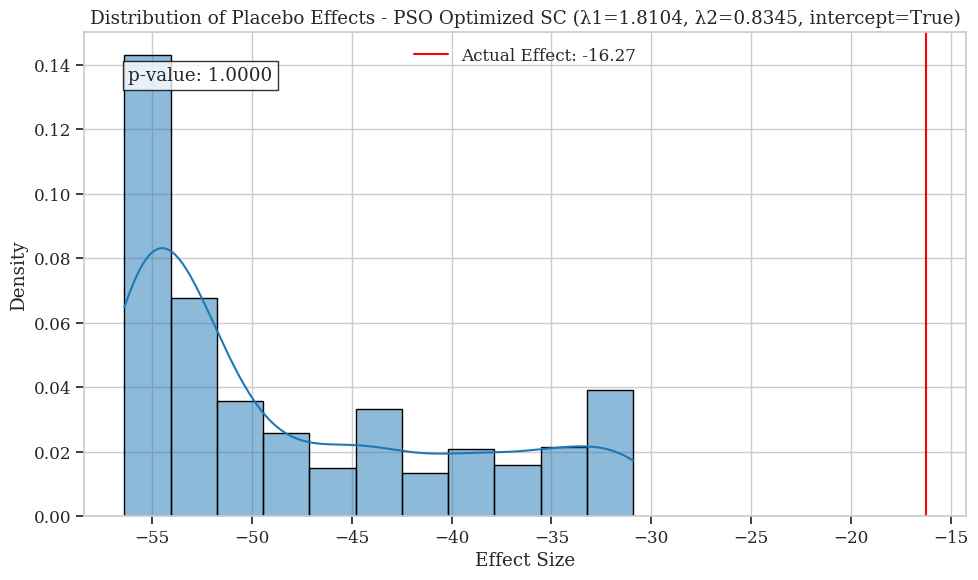


                   CALIFORNIA PROPOSITION 99 ANALYSIS SUMMARY                   
Treated State: California
Treatment Year: 1989
Pre-treatment Years: 1970-1988 (19 years)
Post-treatment Years: 1989-2000 (12 years)
Number of Control States: 47
Excluded Neighboring States: Nevada, Oregon, Arizona

--------------------------------------------------------------------------------
                                RESULTS SUMMARY                                 
--------------------------------------------------------------------------------
                                                 Method Effect                                                         Inference Pre-RMSE % Reduction
                              Difference-in-Differences -24.91                                             SE: 4.815648217065794    11.37       21.4%
                                      Synthetic Control -14.55                                            SE: 29.920633986553838     1.28       12.5%
          

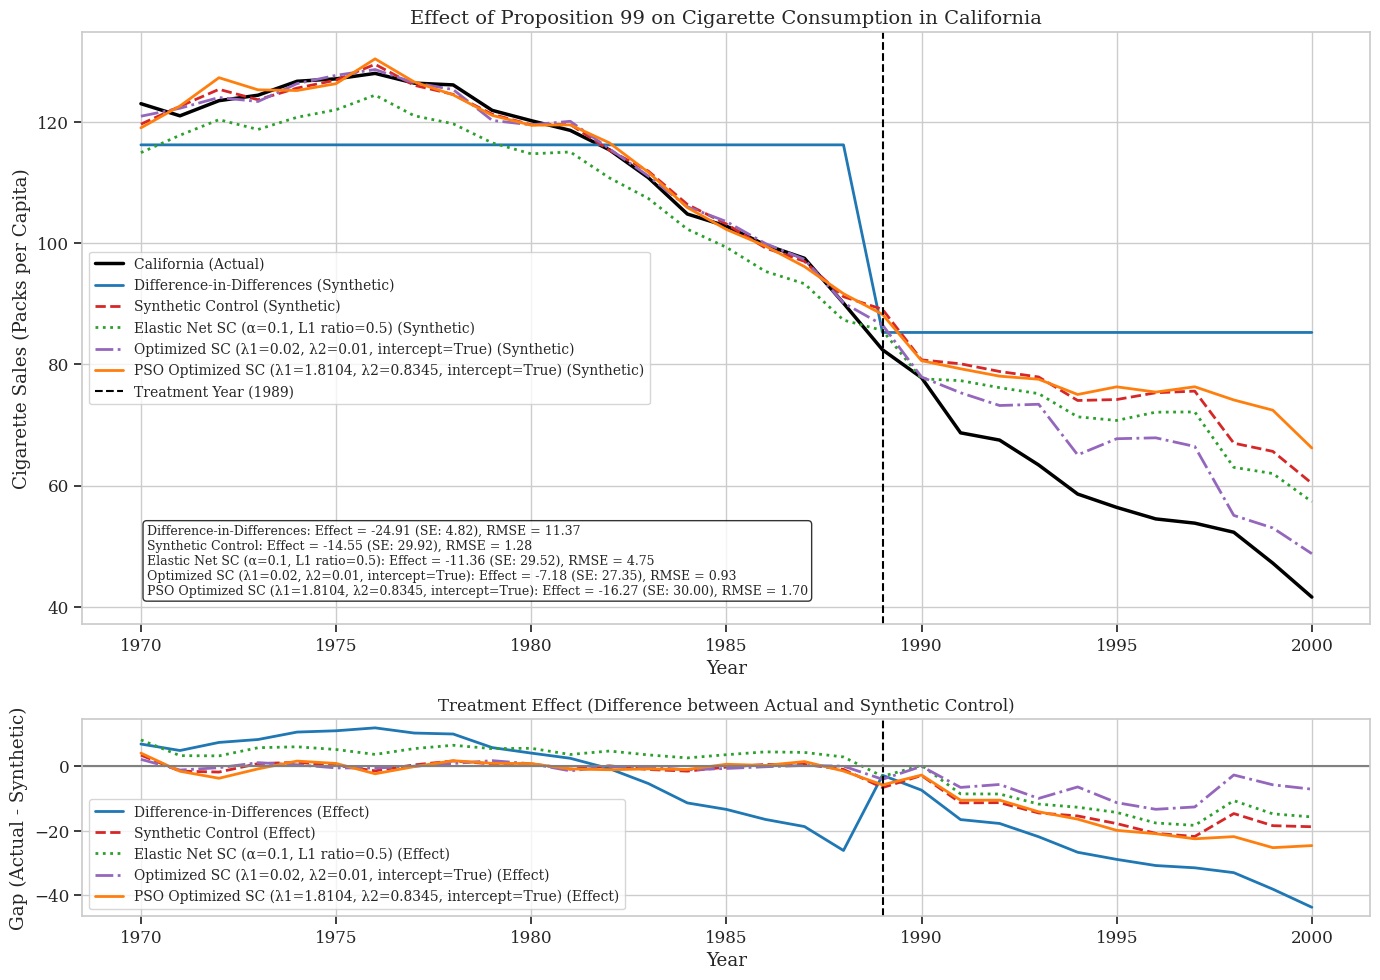

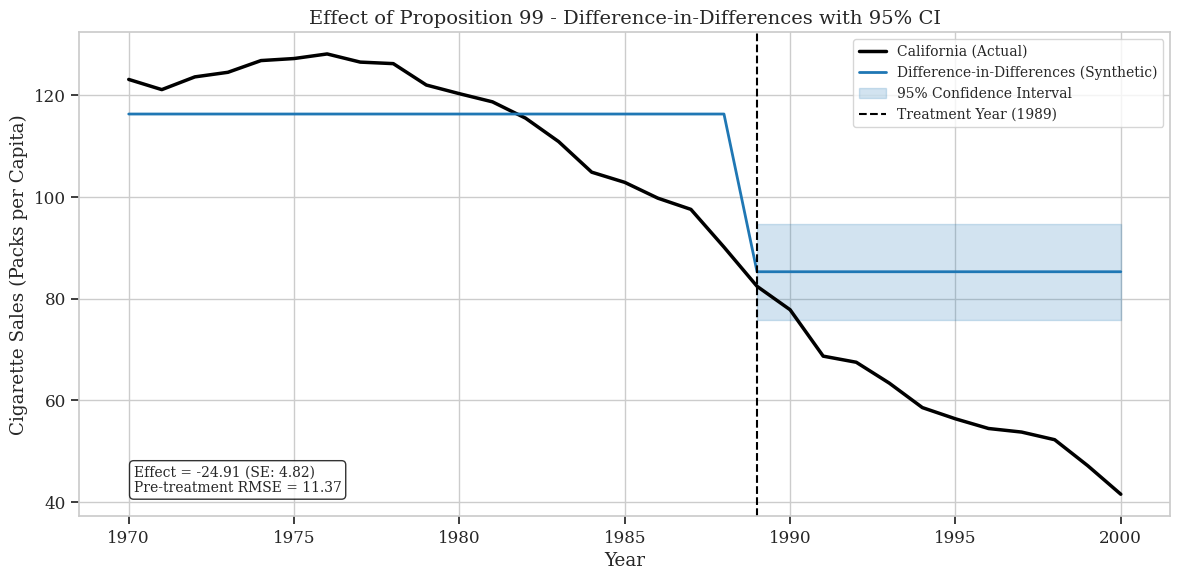

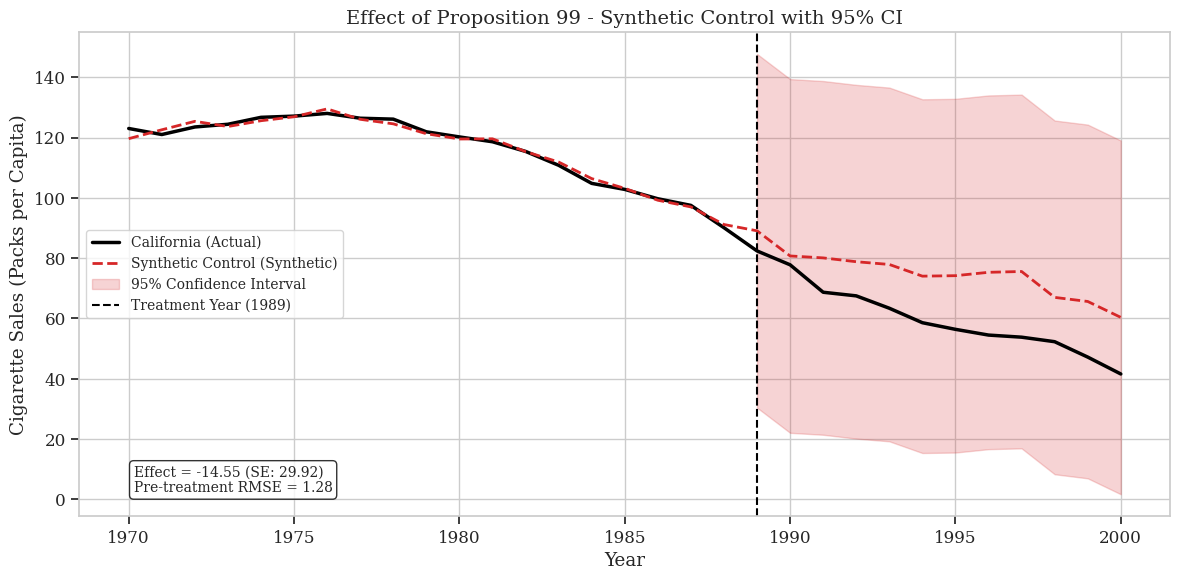

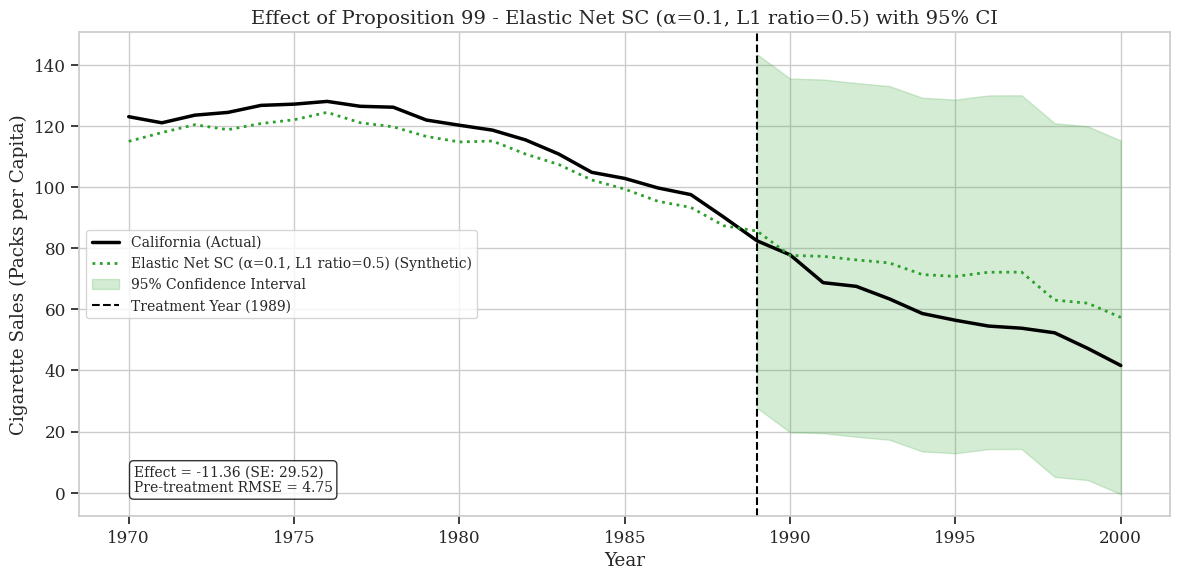

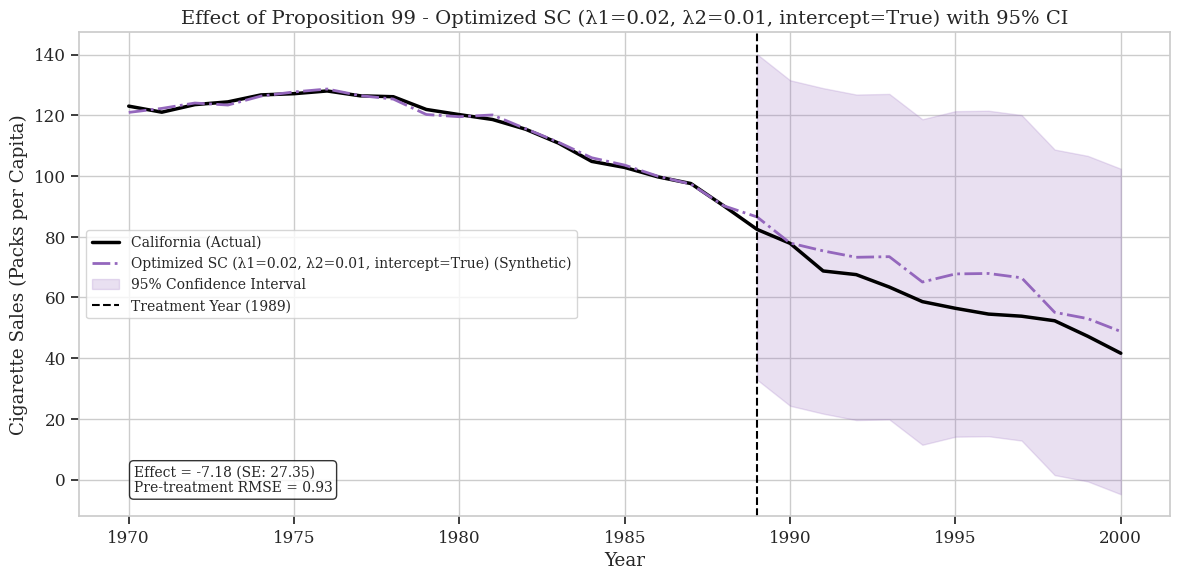

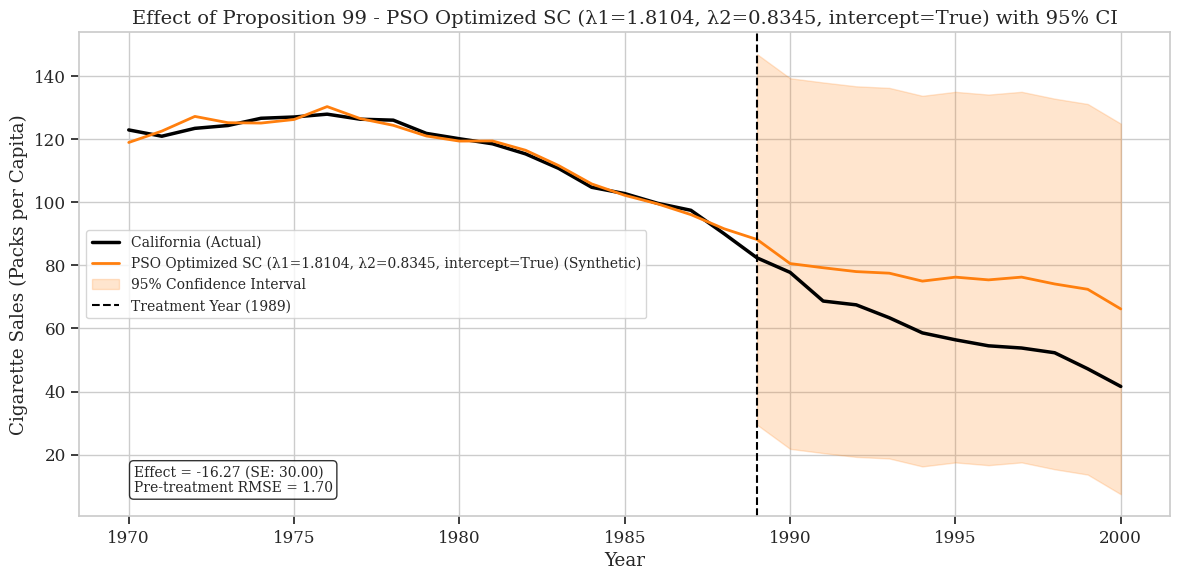

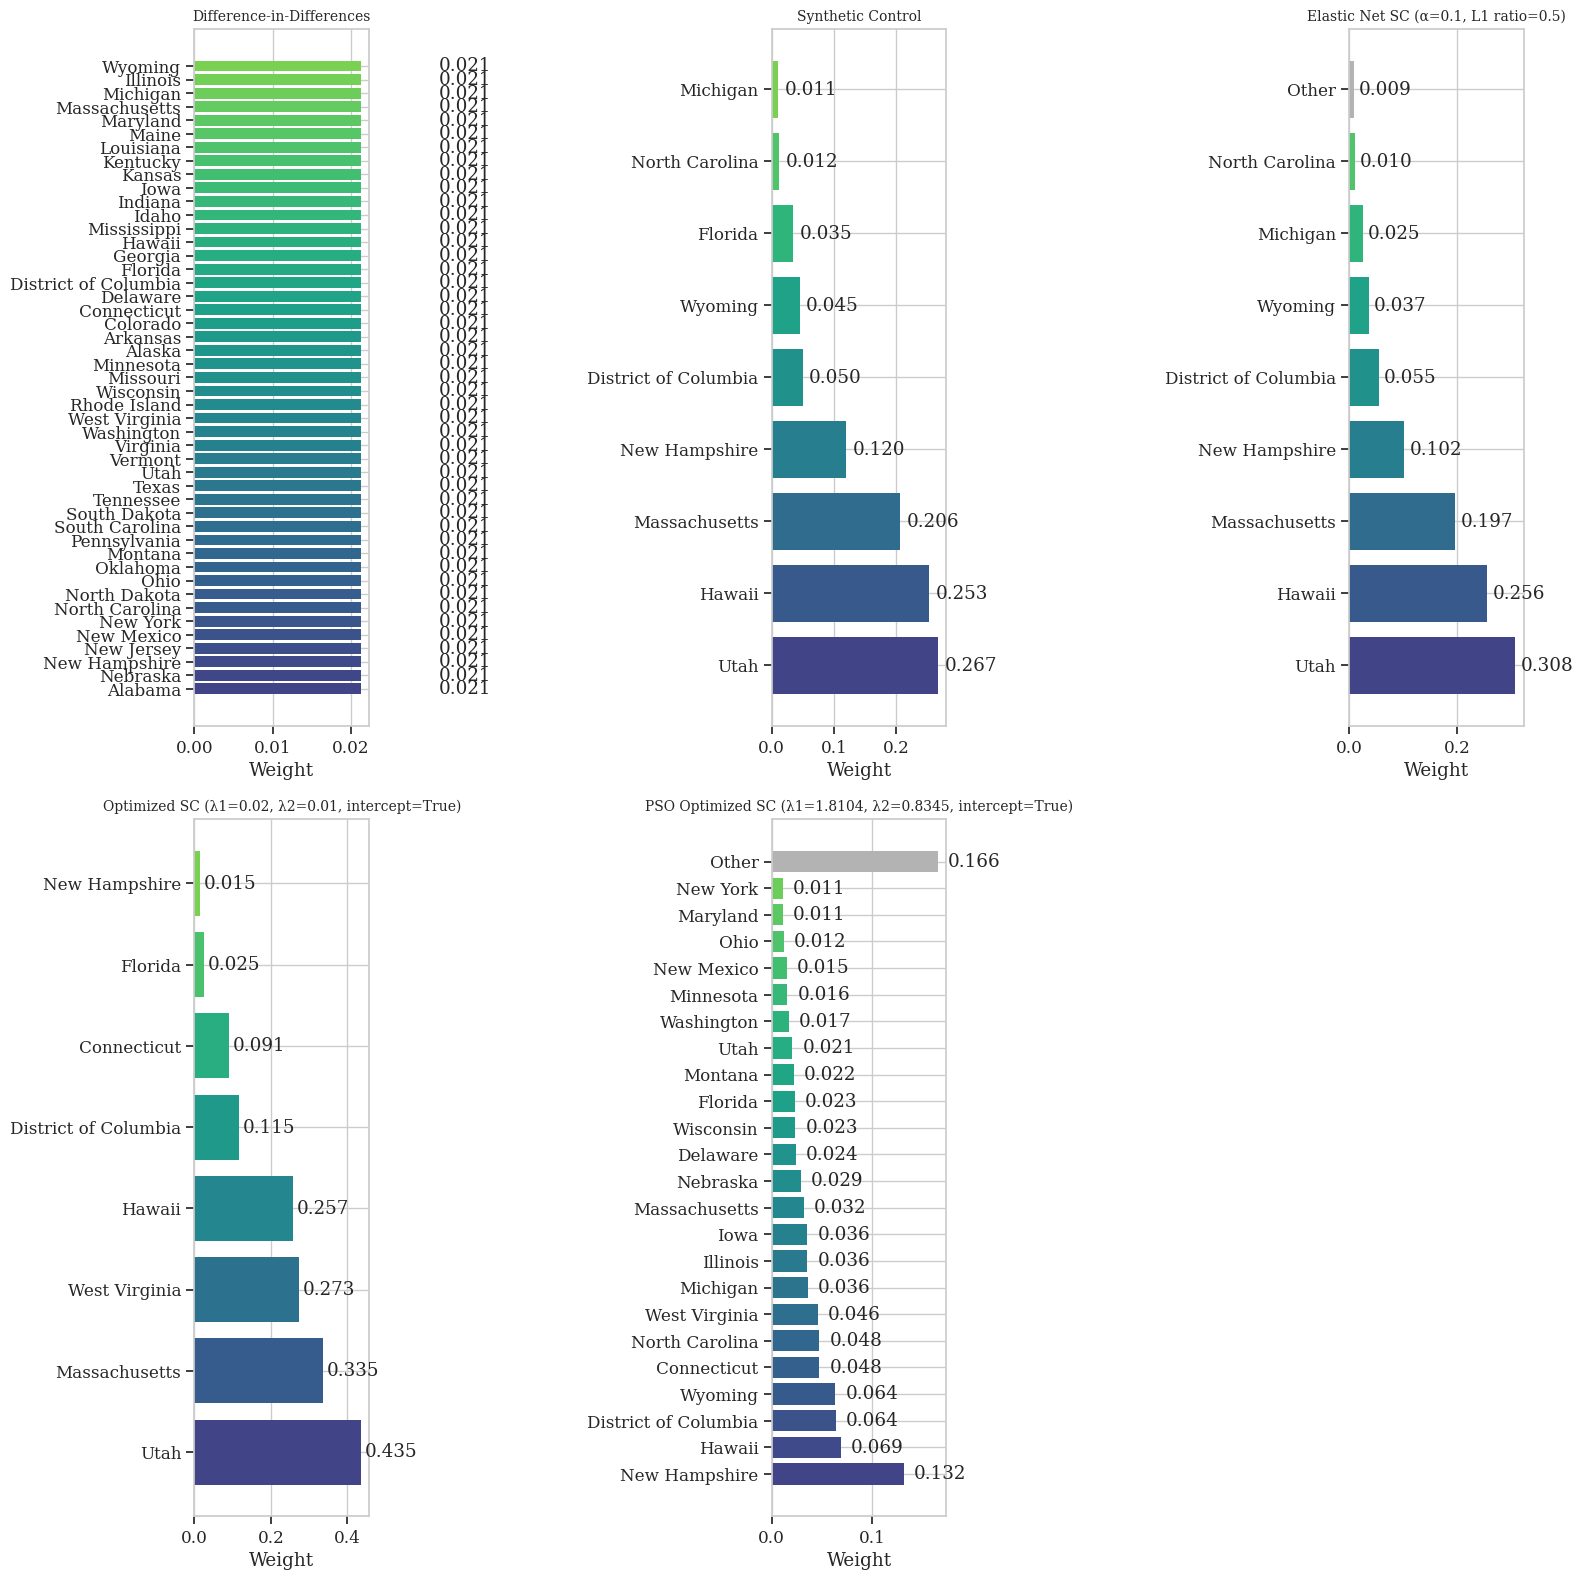

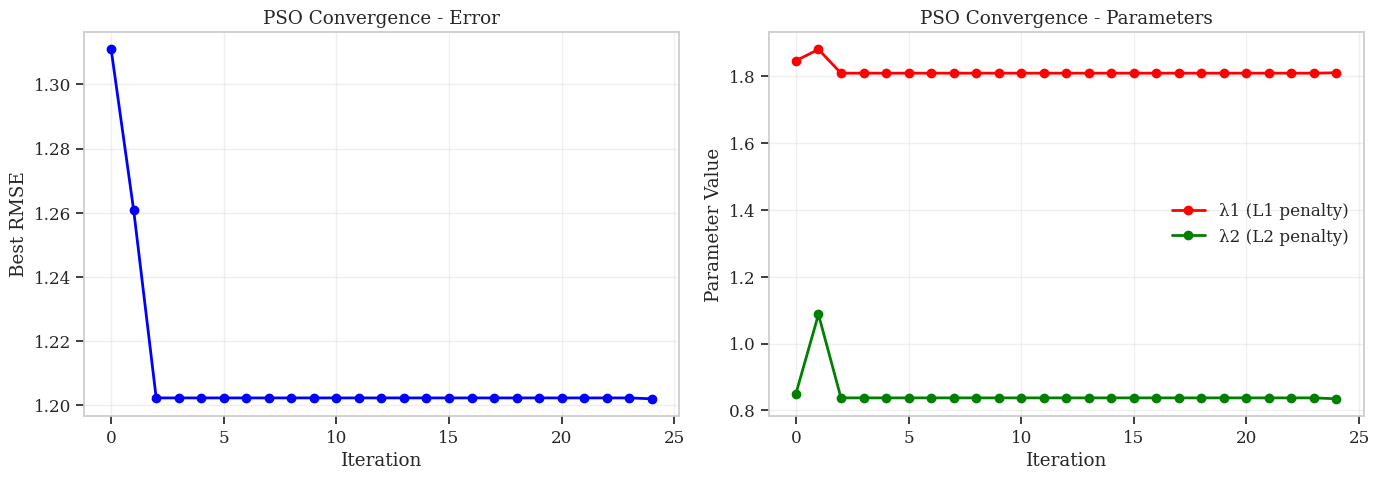

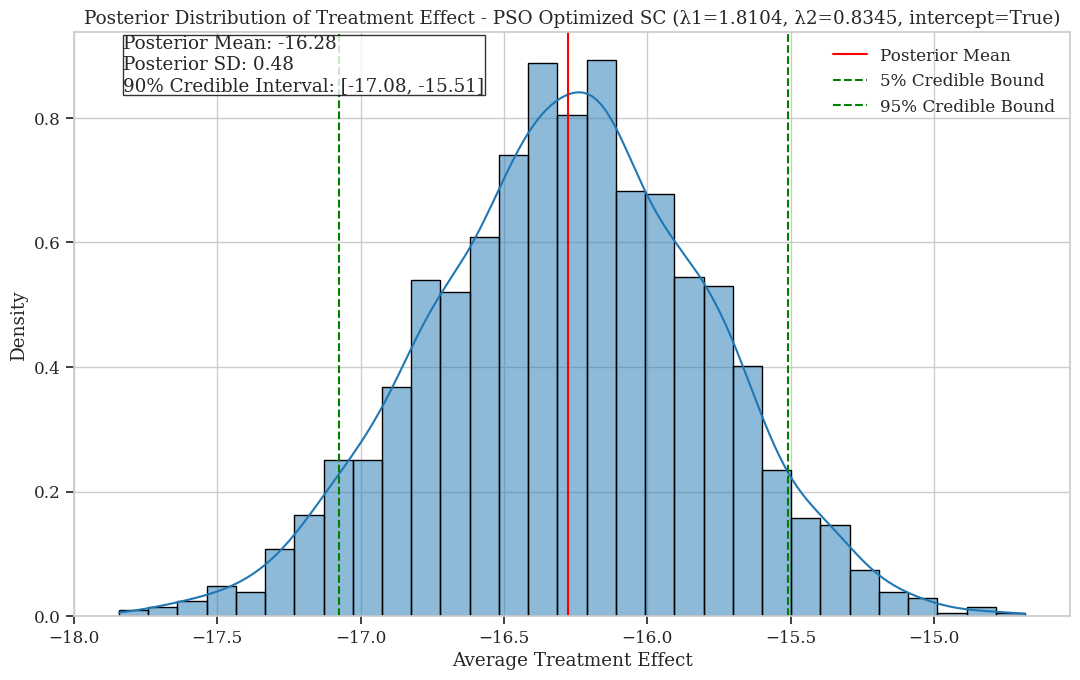

In [20]:
# Execute the full analysis
analyzer = analyze_california_prop99(
    data_path="prop99.csv", 
    run_all_methods=True,
    run_inference=True,
    plot_results=True
)
